# T5 Pre-Training on SGD Dataset

Data-to-Text Conditional Generation \
System Response Text Generation

---


**Practice Module: Practical Language Processing (PLP)**

**Group: 17**

Members:

`Lim Jun Ming`, `A0231523U`

`Tadhg Kennedy`, 

`Gopan Ravikumar Girija`,

# 0. Initialization

## Install necessary modules

In [1]:
# !pip install -U transformers

In [2]:
# !pip install sentencepiece

In [3]:
# !pip install datasets

In [4]:
# !pip install sacrebleu

In [5]:
# !pip install torchinfo

## Imports

In [6]:
import os
# from google.colab import drive

import numpy as np
import pandas as pd
import json
import random
import time
import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import datasets

import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler


## Mounting Drive

In [7]:
# # Mounting to Google Drive
# drive.mount('/content/gdrive')

# # Change Working Directory
# os.chdir('/content/gdrive/My Drive/iss/plp_pm/')

## Pytorch Setup

In [8]:
# Print Torch version
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print('-' * 10)

# Check GPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1.10.1+cu113
11.3
8200
----------
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [9]:
seed=17

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.empty_cache()



In [10]:
!nvidia-smi

Tue Apr 12 00:36:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 17%   59C    P0    50W / 400W |   2907MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## File Paths

In [11]:
basedir = os.getcwd()
datadir = os.path.join(basedir, 'Data')
print(basedir)
print(datadir)



D:\Personal\Education\NUS-ISS Mtech IS\Course Materials\4. Practical Language Processing (PLP)\0. PLP Project\Code\NLG
D:\Personal\Education\NUS-ISS Mtech IS\Course Materials\4. Practical Language Processing (PLP)\0. PLP Project\Code\NLG\Data


# 1. Data Preparation

## >> DATA PARAMETERS

In [12]:
# Data Parameters

BATCH_SIZE = 48
MAX_LENGTH = 128 # With some buffer given the longest input number of token = 130
MODEL_NAME = 't5-small'

## Load Data

In [13]:
# Read Data File

train_path = os.path.join(datadir, 'SGD_Train_Code_SYS_1.csv')
val_path = os.path.join(datadir, 'SGD_Dev_Code_SYS_1.csv')
test_path = os.path.join(datadir, 'SGD_Test_Code_SYS_1.csv')

train_df = pd.read_csv(train_path, index_col=0)
val_df = pd.read_csv(val_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)

# Check if NA data 
print(pd.isna(train_df).sum())
print(pd.isna(val_df).sum())
print(pd.isna(test_df).sum())

print(test_df[pd.isna(test_df['Text'])])

# Replace NA with empty string
test_df['Text'] = test_df['Text'].apply(lambda x: '' if pd.isna(x) else x)

# Code & Utterance

train_code = train_df['Code']
train_text = train_df['Text']

val_code = val_df['Code']
val_text = val_df['Text']

test_code = test_df['Code']
test_text = test_df['Text']

print(train_df.shape)
print(train_df.columns)
train_df.head()


Code    0
Text    0
dtype: int64
Code    0
Text    0
dtype: int64
Code    0
Text    2
dtype: int64
                     Code Text
1777  RideSharing GOODBYE  NaN
4102     Services GOODBYE  NaN
(164982, 2)
Index(['Code', 'Text'], dtype='object')


,Code,Text
0,Restaurants REQUEST ( city = ? ),Do you have a specific which you want the eati...
1,"Restaurants REQUEST ( cuisine = Mexican , Ital...","Is there a specific cuisine type you enjoy, su..."
2,Restaurants OFFER ( restaurant_name = 71 Saint...,I see that at 71 Saint Peter there is a good r...
3,Restaurants INFORM ( street_address = 71 North...,If you want to go to this restaurant you can f...
4,Restaurants INFORM ( phone_number = 408-971-85...,If you want to phone them you can at 408-971-8...


In [14]:
# Check Dataset

print('Number of samples in Train Dataset      :', len(train_df))
print('Number of samples in Validation Dataset :', len(val_df))
print('Number of samples in Test Dataset       :', len(test_df))

Number of samples in Train Dataset      : 164982
Number of samples in Validation Dataset : 24363
Number of samples in Test Dataset       : 42297


In [15]:
# Quick Check for token length

train_code_len = train_code.apply(lambda x: len(x.split(' ')) if not pd.isna(x) else 0).to_numpy()
train_text_len = train_text.apply(lambda x: len(x.split(' ')) if not pd.isna(x) else 0).to_numpy()

val_code_len   = val_code.apply(lambda x: len(x.split(' ')) if not pd.isna(x) else 0).to_numpy()
val_text_len   = val_text.apply(lambda x: len(x.split(' ')) if not pd.isna(x) else 0).to_numpy()

test_code_len  = test_code.apply(lambda x: len(x.split(' ')) if not pd.isna(x) else 0).to_numpy()
test_text_len  = test_text.apply(lambda x: len(x.split(' ')) if not pd.isna(x) else 0).to_numpy()

data_code_len = np.concatenate([train_code_len, val_code_len, test_code_len])
data_text_len = np.concatenate([train_text_len, val_text_len, test_text_len])

data_len = data_code_len + data_text_len

print('Longest Input Number of Tokens for input code   :', data_code_len.max())
print('Shortest Input Number of Tokens for input code  :', data_code_len.min())
print('Longest Input Number of Tokens for output text  :', data_text_len.max())
print('Shortest Input Number of Tokens for output text :', data_text_len.min())

Longest Input Number of Tokens for input code   : 47
Shortest Input Number of Tokens for input code  : 2
Longest Input Number of Tokens for output text  : 84
Shortest Input Number of Tokens for output text : 1


## Train-Val Split

For full dataset pre-training

In [16]:
# Combine Data 

data_df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

# Remove invalid data point

data_df_mask = np.asarray([not(x=='') for x in data_df['Text']])
data_df = data_df.iloc[data_df_mask, :].reset_index(drop=True)
print(f'Number of samples: {len(data_df)}')
print('=' * 70)


# Extract first Domain of each samples

data_domain = pd.Series([x.split(' ')[0] for x in data_df['Code']])
print('List of Domain in Dataset: ')
print('-' * 30)
print(data_domain.unique())
print('=' * 70)
data_df.head()

Number of samples: 231640
List of Domain in Dataset: 
------------------------------
['Restaurants' 'Media' 'Events' 'Music' 'Movies' 'Flights' 'RideSharing'
 'RentalCars' 'Buses' 'Hotels' 'Services' 'Homes' 'Banks' 'Calendar'
 'Weather' 'Travel' 'Alarm' 'Payment' 'Trains' 'Messaging']


,Code,Text
0,Restaurants REQUEST ( city = ? ),Do you have a specific which you want the eati...
1,"Restaurants REQUEST ( cuisine = Mexican , Ital...","Is there a specific cuisine type you enjoy, su..."
2,Restaurants OFFER ( restaurant_name = 71 Saint...,I see that at 71 Saint Peter there is a good r...
3,Restaurants INFORM ( street_address = 71 North...,If you want to go to this restaurant you can f...
4,Restaurants INFORM ( phone_number = 408-971-85...,If you want to phone them you can at 408-971-8...


In [17]:
# Train-Val Split
idx = range(len(data_df))
stratify_label = data_domain

VAL_RATIO = 0.2

train_idx, val_idx, _, _ = train_test_split(idx, stratify_label, stratify=stratify_label, test_size=VAL_RATIO, random_state=seed)

data_train_df = data_df.iloc[train_idx, :].reset_index(drop=True)
data_val_df = data_df.iloc[val_idx, :].reset_index(drop=True)

print('Number of training samples   :', len(data_train_df))
print('Number of validation samples :', len(data_val_df))

Number of training samples   : 185312
Number of validation samples : 46328


## Load GPT2 Tokenizer

In [18]:
# Initialize GPT2 Tokenizer from HuggingFace-Transformer

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
# num_special_tokens = tokenizer.add_special_tokens(SPECIAL_TOKENS)
print(f'Special Tokens Added, vocab size = {len(tokenizer)}')

Special Tokens Added, vocab size = 32100


In [19]:
# Test Tokenizer

sample_id = 62539
try_code = train_code[sample_id]
try_text = train_text[sample_id]
test_tokenized = tokenizer(try_text, 
                           padding='max_length', 
                           max_length=MAX_LENGTH, 
                           truncation=True, 
                           return_attention_mask = True,
                           return_tensors = 'pt')
print('-' * 100)
print('Original Text:')
print('-' * 100)
print(try_code)
print(try_text)
print('')
print('-' * 100)
print('Tokenization Outputs:')
print('-' * 100)
print(test_tokenized)
print('Decoded Text:')
print('-' * 100)
print(tokenizer.decode(token_ids=test_tokenized['input_ids'][0]))

----------------------------------------------------------------------------------------------------
Original Text:
----------------------------------------------------------------------------------------------------
Flights CONFIRM ( origin_city = Mexico City ; destination_city = San Francisco ; airlines = American Airlines ; departure_date = March 11th ; return_date = March 13th ; outbound_departure_time = 2:55 pm ; inbound_departure_time = 1:20 pm ; seating_class = Economy ; passengers = 2 )
Okay let's confirm the details. The flight is from Mexico City to San Francisco it is an American Airlines flight, the departure date is March 11th the return day is March 13th the onward flight leaves at 2:55 p.m. the return flight leaves at 1:20 p.m. The seating class is economy and the number of passengers is to the onward flight leaves at 2:55 pm the return flight leaves at 1:20 pm. The seating class is economy and the number of passengers is 2.

---------------------------------------------

## Pytorch Dataset

In [20]:
# Pytorch Dataset
# >> Encodes original text with GPT2 Tokenizer
# >> The control code and target utterance are structured into the following form:
# >> [BOS] CONTROL_CODE [SEP] TARGET_UTTERANCE [EOS]


class TOD_Dataset(torch.utils.data.Dataset):
  def __init__(self, data, tokenizer, process_length):

    self.input_code = data['Code']
    self.output_target = data['Text']

    # Tokenizer Input_code
    self.input_tokenized = tokenizer.batch_encode_plus(self.input_code,
                                                       padding='max_length',
                                                       max_length=process_length,
                                                       truncation=True, 
                                                       return_attention_mask = True, 
                                                       return_tensors = 'pt')

    self.input_ids = self.input_tokenized['input_ids']
    self.input_attn = self.input_tokenized['attention_mask']

    # Tokenizer Input_code
    self.target_tokenized = tokenizer.batch_encode_plus(self.output_target,
                                                        padding='max_length',
                                                        max_length=process_length,
                                                        truncation=True, 
                                                        return_attention_mask = True, 
                                                        return_tensors = 'pt')

    self.target_ids = self.target_tokenized['input_ids']
    self.target_ids[self.target_ids == tokenizer.pad_token_id] = -100


  def __len__(self):
    return len(self.input_code)

  def __getitem__(self, idx):
    input_ids   = self.input_ids[idx]
    input_mask  = self.input_attn[idx]
    target_ids  = self.target_ids[idx]

    
    return input_ids, input_mask, target_ids

## Dataset & Dataloader

In [21]:
# # Create Dataset
# st = time.time()

# train_dataset = TOD_Dataset(train_df, tokenizer, MAX_LENGTH)
# val_dataset = TOD_Dataset(val_df, tokenizer, MAX_LENGTH)
# test_dataset = TOD_Dataset(test_df, tokenizer, MAX_LENGTH)

# en = time.time()

# print('Total Processing Time : {0:d} secs'.format(int(en-st)))
# # print('Average Processing Time per data point : {0:.2f} secs'.format(round((en-st)/(len(train_dataset) + len(val_dataset) + len(test_dataset))),2))


In [22]:
# # Create Dataloader
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [23]:
# Create Dataset (FUll for pre-training)

st = time.time()

train_dataset = TOD_Dataset(data_train_df, tokenizer, MAX_LENGTH)
val_dataset = TOD_Dataset(data_val_df, tokenizer, MAX_LENGTH)

en = time.time()

print('Total Processing Time : {0:d} secs'.format(int(en-st)))



Total Processing Time : 53 secs


In [24]:
# # Create Dataloader (FUll for pre-training)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Check Dataloader

In [25]:
# Check Dataloader

print(len(train_loader))
print(train_loader.batch_size)

for idx, (input_ids, input_mask, target_ids) in enumerate(train_loader):
  print(idx)
  print(input_ids.size())
  print(input_mask.size())
  print(target_ids.size())
  # print(target_mask.size())
  
  print(input_ids) 
  print(input_mask)
  print(target_ids)
  # print(target_mask)
  
  break

3861
48
0
torch.Size([48, 128])
torch.Size([48, 128])
torch.Size([48, 128])
tensor([[11137,  4486,  6058,  ...,     0,     0,     0],
        [16736,     7, 28299,  ...,     0,     0,     0],
        [13300,  3347, 20805,  ...,     0,     0,     0],
        ...,
        [ 5703,    15,     7,  ...,     0,     0,     0],
        [13300,  3388, 24030,  ...,     0,     0,     0],
        [14093, 28299,   279,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[ 696, 5038,   19,  ..., -100, -100, -100],
        [ 499, 5565,    5,  ..., -100, -100, -100],
        [  27,   54,   92,  ..., -100, -100, -100],
        ...,
        [ 363,   19,   39,  ..., -100, -100, -100],
        [1129,  503,    6,  ..., -100, -100, -100],
        [2321,   34,  514,  ..., -100, -100, -100]])


# 2. Model Defintion & Functions

## Test Model Run

In [26]:
# import datasets

# metric = datasets.load_metric('sacrebleu')
# # reference_batch = [["hello there general kenobi"], ["foo bar foobar"]]
# # sys_batch = ["hello there general kenobi", "foo bar foobar"]
# reference_batch = [["what are you doing"], ["what are you doing"]]
# sys_batch = ['what are test', 'testing']
# metric.add_batch(predictions=sys_batch, references=reference_batch)
# print(metric.compute(smooth_method="add-k"))

# metric = datasets.load_metric('sacrebleu')
# reference_batch = [["what are you doing"]]
# sys_batch = ['what are test']
# metric.add_batch(predictions=sys_batch, references=reference_batch)
# print(metric.compute(smooth_method="add-k"))

# metric = datasets.load_metric('sacrebleu')
# reference_batch = [["what are you doing"]]
# sys_batch = ['doing']
# metric.add_batch(predictions=sys_batch, references=reference_batch)
# print(metric.compute(smooth_method="add-k"))

In [27]:
# Test Model - Fast Run Single Batch
testmodel_name = 't5-small'
# testmodel = GPT2_Fine_Tune(model_name, tokenizer)

config = T5Config.from_pretrained(testmodel_name, output_hidden_states=False)
testmodel = T5ForConditionalGeneration.from_pretrained(testmodel_name, config=config)

# if ADD_SPECIAL_TOKENS:
#   testmodel.resize_token_embeddings(len(tokenizer))

testmodel.eval()
with torch.no_grad():
  print(summary(testmodel))

  for load_input_ids, load_input_mask, load_target_ids in train_loader:
    test_loader_input_ids = load_input_ids
    test_loader_input_mask = load_input_mask
    test_loader_target_ids = load_target_ids
    break

  test_output = testmodel(input_ids=load_input_ids , attention_mask=load_input_mask, labels=load_target_ids)
  test_generate = testmodel.generate(input_ids=load_input_ids, max_length=MAX_LENGTH)
  print(test_generate.size())
  print(test_output[0].size())
  print(test_output[1].size())
  print(tokenizer.decode(load_input_ids[0], skip_special_tokens=True))
  print(tokenizer.decode(test_generate[0], skip_special_tokens=True))
metric = datasets.load_metric('sacrebleu')
metric.add_batch(predictions=[tokenizer.decode(test_generate[0], skip_special_tokens=True)], references=[[tokenizer.decode(load_input_ids[0], skip_special_tokens=True)]])
metric.compute(smooth_method="add-k")

Layer (type:depth-idx)                                  Param #
T5ForConditionalGeneration                              --
├─Embedding: 1-1                                        16,449,536
├─T5Stack: 1-2                                          --
│    └─Embedding: 2-1                                   (recursive)
│    └─ModuleList: 2-2                                  --
│    │    └─T5Block: 3-1                                3,147,008
│    │    └─T5Block: 3-2                                3,146,752
│    │    └─T5Block: 3-3                                3,146,752
│    │    └─T5Block: 3-4                                3,146,752
│    │    └─T5Block: 3-5                                3,146,752
│    │    └─T5Block: 3-6                                3,146,752
│    └─T5LayerNorm: 2-3                                 512
│    └─Dropout: 2-4                                     --
├─T5Stack: 1-3                                          --
│    └─Embedding: 2-5                             

{'score': 87.20178958045501,
 'counts': [20, 19, 17, 15],
 'totals': [21, 21, 20, 19],
 'precisions': [95.23809523809524, 90.47619047619048, 85.0, 78.94736842105263],
 'bp': 1.0,
 'sys_len': 21,
 'ref_len': 21}

## Train Step Function

In [28]:
# Train Function

def train_model(model, tokenizer, dataloaders, optimizer, bleu_scorer, num_epochs, decode_beam, decode_topp, callback_path_greedy, callback_path_beam, callback_path_topp):
    start_time = time.time()

    train_hist = {'train_loss'      : [],
                  'val_loss'        : [],
                  'val_bleu_greedy' : [],
                  'val_bleu_beam'   : [],
                  'val_bleu_topp'   : []}
    
    best_val_bleu_greedy = 0
    best_val_bleu_beam = 0
    best_val_bleu_topp = 0
    best_model_state_greedy = None
    best_model_state_beam = None
    best_model_state_topp = None

    for epoch in range(num_epochs):
        time_0 = time.time()

        print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_sample_count = 0
            running_bleu_greedy = 0.0
            running_bleu_beam = 0.0
            running_bleu_topp = 0.0

            # iterate over dataloader
            for input_ids, attention_mask, labels in dataloaders[phase]:
                # Send to GPU
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                # Initialize gradients
                model.zero_grad()

                # Fit to model
                output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = output[0]
                logits = output[1]

                # Calculate Gradients & Backpropagation
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Update Loss History
                sample_count = input_ids.size()[0] # Batch size
                running_loss += loss.detach().cpu() * sample_count
                running_sample_count += sample_count

                # Calculate BLEU Score for validation
                if phase == 'val':
                    preds_greedy = model.generate(input_ids=input_ids, max_length=labels.size()[-1]).detach().cpu()
                    preds_beam   = model.generate(input_ids=input_ids, max_length=labels.size()[-1], num_beams=decode_beam, early_stopping=True).detach().cpu()
                    preds_topp   = model.generate(input_ids=input_ids, max_length=labels.size()[-1], top_p=decode_topp, top_k=0).detach().cpu()

                    for i in range(preds_greedy.size()[0]):
                        valid_ids_labels = torch.clone(labels[i]).detach().cpu()
                        valid_ids_labels[valid_ids_labels==-100] = 0
                        true_text = tokenizer.decode(valid_ids_labels, skip_special_tokens=True)

                        pred_text_greedy = tokenizer.decode(preds_greedy[i], skip_special_tokens=True)
                        pred_text_beam = tokenizer.decode(preds_beam[i], skip_special_tokens=True)
                        pred_text_topp = tokenizer.decode(preds_topp[i], skip_special_tokens=True)

                        # Greedy Search BLEU
                        bleu_scorer.add_batch(predictions=[pred_text_greedy], references=[[true_text]])
                        score = bleu_scorer.compute(smooth_method="add-k")['score']
                        running_bleu_greedy += score

                        # Beam Search BLEU
                        bleu_scorer.add_batch(predictions=[pred_text_beam], references=[[true_text]])
                        score = bleu_scorer.compute(smooth_method="add-k")['score']
                        running_bleu_beam += score

                        # Topp Search BLEU
                        bleu_scorer.add_batch(predictions=[pred_text_topp], references=[[true_text]])
                        score = bleu_scorer.compute(smooth_method="add-k")['score']
                        running_bleu_topp += score

            # Calculate Epoch Statistics
            epoch_loss = running_loss / running_sample_count
            epoch_val_bleu_greedy = round(running_bleu_greedy / running_sample_count, 2)
            epoch_val_bleu_beam = round(running_bleu_beam / running_sample_count, 2)
            epoch_val_bleu_topp = round(running_bleu_topp / running_sample_count, 2)

            print('{} - Loss: {:.4f}'.format(phase, epoch_loss))
            if phase == 'val':
                print('val - Greedy-BLEU: {:.2f} | Beam-BLEU: {:.2f} | Topp-BLEU: {:.2f}'.format(epoch_val_bleu_greedy, epoch_val_bleu_beam, epoch_val_bleu_topp))

            # Update Callback for Best Loss Model State Dict - Greedy Search
            if epoch_val_bleu_greedy > best_val_bleu_greedy:
                best_val_bleu_greedy = epoch_val_bleu_greedy
                best_model_state_greedy = model.state_dict()
                torch.save(best_model_state_greedy, callback_path_greedy)

            # Update Callback for Best Loss Model State Dict - Beam Search
            if epoch_val_bleu_beam > best_val_bleu_beam:
                best_val_bleu_beam = epoch_val_bleu_beam
                best_model_state_beam = model.state_dict()
                torch.save(best_model_state_beam, callback_path_beam)

            # Update Callback for Best Loss Model State Dict - Top-p Search
            if epoch_val_bleu_topp > best_val_bleu_topp:
                best_val_bleu_topp = epoch_val_bleu_topp
                best_model_state_topp = model.state_dict()
                torch.save(best_model_state_topp, callback_path_topp)

            # Update history
            if phase == 'train':
                train_hist['train_loss'].append(epoch_loss.detach().cpu())
            if phase == 'val':
                train_hist['val_loss'].append(epoch_loss.detach().cpu())
                train_hist['val_bleu_greedy'].append(epoch_val_bleu_greedy)
                train_hist['val_bleu_beam'].append(epoch_val_bleu_beam)
                train_hist['val_bleu_topp'].append(epoch_val_bleu_topp)

        # Printing Epoch training info
        time_elapsed = round(time.time() - time_0,0)
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('')

    load_dict = torch.load(callback_path_greedy)
    model.load_state_dict(load_dict)

    total_elapsed = round(time.time()-start_time,0)
    avg_per_epoch = round((time.time()-start_time) / num_epochs, 0)
    avg_per_batch = round((time.time()-start_time) / (num_epochs * dataloaders['train'].__len__()), 0)
    total_training_time = str(datetime.timedelta(seconds=total_elapsed))
    avg_epoch_training_time = str(datetime.timedelta(seconds=avg_per_epoch))
    avg_batch_training_time = str(datetime.timedelta(seconds=avg_per_batch))

    print('-' * 70)
    print('Training Complete!')
    print('-' * 70)
    print('Batch Size used                 : {0:d}'.format(dataloaders['train'].batch_size))
    print('Total training took             : {:} (h:mm:ss)'.format(total_training_time))              
    print('Average Training Time per Epoch : {:} (h:mm:ss)'.format(avg_epoch_training_time))
    print('Average Training Time per batch : {:} (h:mm:ss)'.format(avg_batch_training_time))  
    print('')
    print('-' * 70 )
    print('Best Validation BLEU Score - Greedy Search : {0:.2f}'.format(best_val_bleu_greedy))
    print('Best Validation BLEU Score - Beam Search   : {0:.2f}'.format(best_val_bleu_beam))
    print('Best Validation BLEU Score - Topp Search   : {0:.2f}'.format(best_val_bleu_topp))
    print('Model callback complete')
    return model, train_hist



# 3. Model Training

## >> MODEL PARAMETERS

In [29]:
# testrun_train_dataset = TOD_Dataset(data_train_df[:20], tokenizer, MAX_LENGTH)
# testrun_train_loader = torch.utils.data.DataLoader(testrun_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# testrun_val_dataset = TOD_Dataset(data_val_df[:2], tokenizer, MAX_LENGTH)
# testrun_val_loader = torch.utils.data.DataLoader(testrun_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# print(testrun_train_loader.batch_size)
# print(testrun_train_loader.__len__())

In [32]:
# Model Training Parameters
MODEL_NAME = 't5-small'
LR = 5e-4
EPOCH = 10
OPTIM = torch.optim.Adam

# Text Generation Decoding Parameters
DECODE_BEAM = 5
DECODE_TOPP = 0.8

# Callback Save Paths
SAVE_FILE_NAME = MODEL_NAME + '_FULL_PRETRAIN'
CALLBACK_PATH_GREEDY = os.path.join(basedir, 'model_state\\'+ SAVE_FILE_NAME +'_GREEDY.pt')
CALLBACK_PATH_BEAM   = os.path.join(basedir, 'model_state\\'+ SAVE_FILE_NAME +'_BEAM.pt')
CALLBACK_PATH_TOPP   = os.path.join(basedir, 'model_state\\'+ SAVE_FILE_NAME +'_TOPP.pt')

# Model State Parameters
MODEL_SETUP_PATH = os.path.join(basedir, 'model_setup\\'+ SAVE_FILE_NAME + '_SETUP' +'.pt')
LOAD_STATE_DICT = False

## Model Training

In [34]:
# Initialize Model

config = T5Config.from_pretrained(MODEL_NAME, output_hidden_states=False)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)

# Continue from Previous Trainingtwq
if LOAD_STATE_DICT:
  load_dict = torch.load(CALLBACK_PATH)
  model.load_state_dict(load_dict)

# Data Dictionary for training
dataloaders_dict = {'train':train_loader, 'val':val_loader}

# Optimizer Initialization
params_to_update = model.parameters()
optim_ft = OPTIM(params_to_update, lr=LR)

# BLEU Metric Scorer
bleu = datasets.load_metric('sacrebleu')

# Secnd Model to GPU
model.to(device)

# Train Model
model, hist = train_model(model, tokenizer, dataloaders_dict, optim_ft, bleu, EPOCH, DECODE_BEAM, DECODE_TOPP, CALLBACK_PATH_GREEDY, CALLBACK_PATH_BEAM, CALLBACK_PATH_TOPP)


======== Epoch 1 / 10 ========
train - Loss: 1.2071
val - Loss: 0.9872
val - Greedy-BLEU: 35.12 | Beam-BLEU: 35.33 | Topp-BLEU: 35.12
Training complete in 101m 48s

======== Epoch 2 / 10 ========
train - Loss: 1.0296
val - Loss: 0.9416
val - Greedy-BLEU: 35.18 | Beam-BLEU: 35.47 | Topp-BLEU: 35.18
Training complete in 103m 0s

======== Epoch 3 / 10 ========
train - Loss: 0.9763
val - Loss: 0.9148
val - Greedy-BLEU: 35.65 | Beam-BLEU: 35.36 | Topp-BLEU: 35.65
Training complete in 102m 45s

======== Epoch 4 / 10 ========
train - Loss: 0.9420
val - Loss: 0.9005
val - Greedy-BLEU: 35.59 | Beam-BLEU: 35.17 | Topp-BLEU: 35.59
Training complete in 104m 12s

======== Epoch 5 / 10 ========
train - Loss: 0.9157
val - Loss: 0.8898
val - Greedy-BLEU: 35.46 | Beam-BLEU: 34.83 | Topp-BLEU: 35.46
Training complete in 104m 16s

======== Epoch 6 / 10 ========
train - Loss: 0.8948
val - Loss: 0.8845
val - Greedy-BLEU: 35.38 | Beam-BLEU: 35.21 | Topp-BLEU: 35.38
Training complete in 103m 38s

======== Ep

In [34]:
data_val_df.iloc[575, :]
data_val_df['Text'][575] == ''

False

## Save Model Setup

In [41]:
model_setup = {'BATCH_SIZE': BATCH_SIZE,
               'EPOCH': EPOCH,
               'OPTIMIZER': str(OPTIM),
               'LEARNING_RATE:': LR,
               'TRAINED_MODEL_STATE_FILE': SAVE_FILE_NAME,
               'TRAINING_HISTORY': hist
              }

setup_file = open(MODEL_SETUP_PATH, 'wb')
pickle.dump(model_setup, setup_file, protocol=pickle.HIGHEST_PROTOCOL)
setup_file.close()

In [39]:
load_file = open(MODEL_SETUP_PATH, 'rb')
load_hist = pickle.load(load_file)
load_file.close()

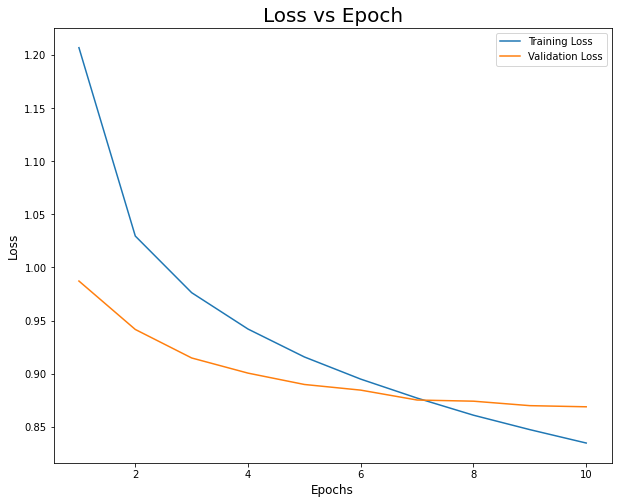

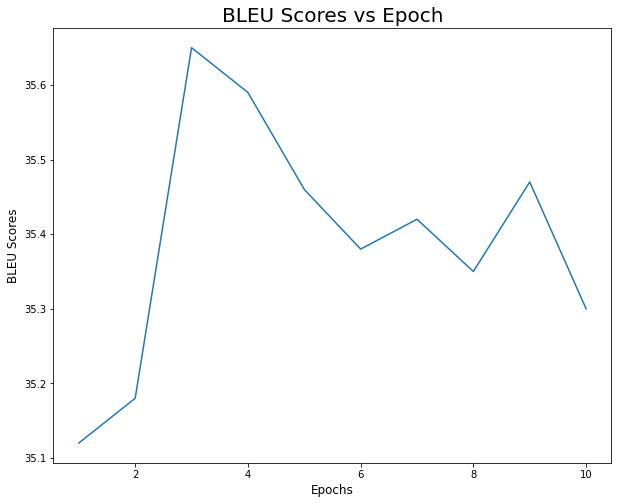

In [40]:
# Loss Chart
train_loss = load_hist['TRAINING_HISTORY']['train_loss'][:10]
val_loss = load_hist['TRAINING_HISTORY']['val_loss'][:10]
val_BLEU = load_hist['TRAINING_HISTORY']['val_bleu'][:10]

x = np.arange(10)+1
plt.figure(figsize=(10,8))
plt.plot(x, train_loss)
plt.plot(x, val_loss)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Epoch', fontsize=20)
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
plt.figure(figsize=(10,8))
plt.plot(x, val_BLEU)
# plt.plot(x, val_BLEU_beam)
# plt.plot(x, val_BLEU_topp)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('BLEU Scores', fontsize=12)
plt.title('BLEU Scores vs Epoch', fontsize=20)
# plt.legend(['Greedy Search', 'Topp Search', 'Beam Search'])
plt.show()

# 4. Evaluation

## Evaluation Function

In [41]:
def calc_bleu(test_loader, model, tokenizer, text_length, beam_size, top_p):
    
    start_time = time.time()
    
    # Generate Predictions
    input_code = []
    actual_text = []
    pred_text_greedy = []
    pred_text_beam = []
    pred_text_topp = []
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            
            labels[labels==-100] = 0
            batch_input_code = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            batch_actual_text = tokenizer.batch_decode(labels, skip_special_tokens=True)
            input_code.extend(batch_input_code)
            actual_text.extend(batch_actual_text)
            
            
            input_ids = input_ids.to(device)
            
            # Greedy Search Generation
            batch_pred_ids_greedy = model.generate(input_ids=input_ids, max_length=text_length).detach().cpu()
            
            # Beam Search with Size = beam_size
            batch_pred_ids_beam = model.generate(input_ids=input_ids, max_length=text_length, num_beams=beam_size, early_stopping=True).detach().cpu()
            
            # Top-p Sampling with probability = top_p
            batch_pred_ids_topp = model.generate(input_ids=input_ids, max_length=text_length, top_p=top_p, top_k=0).detach().cpu()
            
            # Decoding
            batch_pred_text_greedy = tokenizer.batch_decode(batch_pred_ids_greedy, skip_special_tokens=True)
            batch_pred_text_beam = tokenizer.batch_decode(batch_pred_ids_beam, skip_special_tokens=True)
            batch_pred_text_topp = tokenizer.batch_decode(batch_pred_ids_topp, skip_special_tokens=True)
            
            pred_text_greedy.extend(batch_pred_text_greedy)
            pred_text_beam.extend(batch_pred_text_beam)
            pred_text_topp.extend(batch_pred_text_topp)
    
    end_gen_time = time.time() 
    
    print('Text Generation Completed ~')
    
    # Calculate BLEU Score
    num_sample = len(actual_text)
    bleu = datasets.load_metric('sacrebleu')
    
    # Greedy Search BLEU Score
    score_greedy = []
    for i in range(num_sample):
        ref_text = actual_text[i]
        single_pred = pred_text_greedy[i]
        bleu.add_batch(predictions=[single_pred], references=[[ref_text]])
        bleu_score = round(bleu.compute(smooth_method="add-k")['score'],2)
        score_greedy.append(bleu_score)
        
    # Beam Search BLEU Score
    score_beam = []
    for i in range(num_sample):
        ref_text = actual_text[i]
        single_pred = pred_text_beam[i]
        bleu.add_batch(predictions=[single_pred], references=[[ref_text]])
        bleu_score = round(bleu.compute(smooth_method="add-k")['score'],2)
        score_beam.append(bleu_score)
        
    # Top-p search generation BLEU Score
    score_topp = []
    for i in range(num_sample):
        ref_text = actual_text[i]
        single_pred = pred_text_topp[i]
        bleu.add_batch(predictions=[single_pred], references=[[ref_text]])
        bleu_score = round(bleu.compute(smooth_method="add-k")['score'],2)
        score_topp.append(bleu_score)
        
    
    df = pd.DataFrame(np.array([input_code, actual_text, pred_text_greedy, score_greedy, pred_text_beam, score_beam, pred_text_topp, score_topp]).T, 
                      columns=['Input_Code', 'Original_Text', 'Generated_Text_Greedy', 'BLEU_Score_Greedy', 'Generated_Text_Beam', 'BLEU_Score_Beam', 'Generated_Text_Topp', 'BLEU_Score_Topp'])
    
    end_time = time.time()
    
    print('BLEU Score Calculation Completed ~')

    total_time_elapsed = round(end_time-start_time)
    text_generation_time = round(end_gen_time-start_time)
    bleu_calculation_time = round(end_time-end_gen_time)
    avg_generation_time = round(text_generation_time / num_sample, 5)
    avg_bleu_time = round(bleu_calculation_time / num_sample, 5)
    
    print('-' * 70)
    print('Total time taken for running evaluation           : {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Total time taken for text generation              : {:.0f}m {:.0f}s'.format(text_generation_time // 60, text_generation_time % 60))
    print('Total time taken for BLEU score calculations      : {:.0f}m {:.0f}s'.format(bleu_calculation_time // 60, bleu_calculation_time % 60))
    print('Average time taken to generate text 1 sample      : {:.3f}s'.format(avg_generation_time))
    print('Average time taken to calculate BLUE for 1 sample : {:.3f}s'.format(avg_bleu_time))
    print('-' * 70)
    print('Total number of samples generated  :', len(actual_text))
    print('Batch size used in text generation :', test_loader.batch_size)
    
    return df

In [42]:
try_dataset = TOD_Dataset(test_df[:10], tokenizer, MAX_LENGTH)
try_loader = torch.utils.data.DataLoader(try_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(len(try_dataset))
print(len(try_loader))

10
1


## Run Evaluation on Test Dataset

In [44]:
# Load Model
MODEL_NAME = 't5-small'
eval_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)

load_dict = torch.load(CALLBACK_PATH)
eval_model.load_state_dict(load_dict)

# Generate Text and Calculate BLEU
eval_df = calc_bleu(try_loader, eval_model, tokenizer, MAX_LENGTH, 4, 0.8)

Text Generation Completed ~
BLEU Score Calculation Completed ~
----------------------------------------------------------------------
Total time taken for running evaluation           : 0m 7s
Total time taken for text generation              : 0m 5s
Total time taken for BLEU score calculations      : 0m 2s
Average time taken to generate text 1 sample      : 0.500s
Average time taken to calculate BLUE for 1 sample : 0.200s
----------------------------------------------------------------------
Total number of samples generated  : 10
Batch size used in text generation : 48


## BLEU Score Statistics

In [45]:
eval_df

,Input_Code,Original_Text,Generated_Text_Greedy,BLEU_Score_Greedy,Generated_Text_Beam,BLEU_Score_Beam,Generated_Text_Topp,BLEU_Score_Topp
0,Restaurants REQUEST ( time =? ; restaurant_nam...,"Any preference on the restaurant, location and...",Restaurants REQUEST ( time =? ; restaurant_nam...,4.53,Restaurants REQUEST ( time =? ; restaurant_nam...,8.71,Restaurants REQUEST ( time =? ; restaurant_nam...,4.53
1,Restaurants CONFIRM ( restaurant_name = P.f. C...,Please confirm your reservation at P.f. Chang'...,Restaurants CONFIRM ( restaurant_name = P.f. C...,8.01,Restaurants CONFIRM ( restaurant_name = P.f. C...,16.53,Restaurants CONFIRM ( restaurant_name = P.f. C...,8.01
2,Restaurants NOTIFY_FAILURE | Restaurants REQ_MORE,"Sorry, your reservation could not be made. Cou...",Restaurants NOTIFY_FAILURE | Restaurants REQ_M...,0.0,Restaurants NOTIFY_FAILURE | Restaurants REQ_M...,0.0,Restaurants NOTIFY_FAILURE | Restaurants REQ_M...,0.0
3,Restaurants CONFIRM ( restaurant_name = Beniss...,"Sure, please confirm your reservation at Benis...",Restaurants CONFIRM ( restaurant_name = Beniss...,13.54,Restaurants CONFIRM ( restaurant_name = Beniss...,13.54,Restaurants CONFIRM ( restaurant_name = Beniss...,13.54
4,Restaurants INFORM ( price_range = moderate ; ...,"Your reservation has been made. Unfortunately,...",Restaurants INFORM ( price_range = moderate ; ...,1.98,Restaurants INFORM ( price_range = moderate ; ...,1.98,Restaurants INFORM ( price_range = moderate ; ...,1.98
5,Restaurants REQ_MORE,"No worries, could I further assist you?",Restaurants REQ_MORE REQ_MORE REQ_MORE REQ_MOR...,0.0,Restaurants REQ_MORE REQ_MORE REQ_MORE REQ_MOR...,0.0,Restaurants REQ_MORE REQ_MORE REQ_MORE REQ_MOR...,0.0
6,Restaurants GOODBYE,Have a great day ahead!,Restaurants GOODBYE GOODBYE GOODBYE GOODBYE GO...,0.0,Restaurants GOODBYE GOODBYE.,0.0,Restaurants GOODBYE GOODBYE GOODBYE GOODBYE GO...,0.0
7,Restaurants REQUEST ( location =? ),In which city are you trying to book the table?,Restaurants REQUEST ( location =? ) ( location...,8.91,Restaurants REQUEST ( location =? ),9.12,Restaurants REQUEST ( location =? ) ( location...,8.91
8,Restaurants CONFIRM ( restaurant_name = Butter...,Please confirm that you need a table for 2 at ...,Restaurants CONFIRM ( restaurant_name = Butter...,6.26,Restaurants CONFIRM ( restaurant_name = Butter...,6.63,Restaurants CONFIRM ( restaurant_name = Butter...,6.26
9,Restaurants INFORM ( category = Asian ) | Rest...,Your table has been booked successfully and th...,Restaurants INFORM ( category = Asian ) | Rest...,1.72,Restaurants INFORM ( category = Asian ) | Rest...,1.44,Restaurants INFORM ( category = Asian ) | Rest...,1.72


## Save Evaluation Results to File

In [58]:
eval_result_savepath = os.path.join(basedir, 'eval_result\\' + MODEL_NAME + '_eval.csv')

eval_df.to_csv(eval_result_savepath)

In [56]:
basedir

'D:\\Personal\\Education\\NUS-ISS Mtech IS\\Course Materials\\4. Practical Language Processing (PLP)\\0. PLP Project\\Code\\NLG'

In [ ]:
# Initialize Model

config = T5Config.from_pretrained(MODEL_NAME, output_hidden_states=False)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)

# Continue from Previous Trainingtwq
if LOAD_STATE_DICT:
  load_dict = torch.load(CALLBACK_PATH)
  model.load_state_dict(load_dict)

# Data Dictionary for training
dataloaders_dict = {'train':train_loader, 'val':val_loader}

# Optimizer Initialization
params_to_update = model.parameters()
optim_ft = OPTIM(params_to_update, lr=LR)

# BLEU Metric Scorer
bleu = datasets.load_metric('sacrebleu')

# Secnd Model to GPU
model.to(device)

# Train Model
model, hist = train_model(model, tokenizer, dataloaders_dict, optim_ft, bleu, EPOCH, CALLBACK_PATH)

In [ ]:
eval_sample_idx = 1
eval_sample_code = train_code[eval_sample_idx]
eval_sample_text = train_text[eval_sample_idx]
# eval_ids = tokenizer.encode('[BOS]' + eval_sample_code + '[SEP]', return_tensors='pt')
eval_ids = tokenizer.encode('[BOS]' + eval_sample_code + '[SEP]', return_tensors='pt')

eval_ids = eval_ids.to(device)
model.to(device)
model.eval()
eval_greedy_output = model.generate(eval_ids, max_length=192)
eval_greedy_text = tokenizer.decode(eval_greedy_output[0], skip_special_tokens=True)

print('=' * 70)
print('Original Data Point:')
print('-' * 70)
print('Control Code String           :', eval_sample_code)
print('Target Text String            :', eval_sample_text)
print('Tokenized Control Code Tokens :', tokenizer.decode(eval_ids[0]))
print('=' * 70)
print('Model Predictions:')
print('-' * 70)
print('Full Prediction String        :', eval_greedy_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Original Data Point:
----------------------------------------------------------------------
Control Code String           : Restaurants REQUEST ( city )
Target Text String            : Do you have a specific which you want the eating place to be located at?
Tokenized Control Code Tokens : [BOS] Restaurants REQUEST ( city ) [SEP]
Model Predictions:
----------------------------------------------------------------------
Full Prediction String        : Restaurants REQUEST ( city )I see that city. I would like to make a reservation there.


In [ ]:
play_text = train_code[sample_id]
play_input_ids = tokenizer.encode(play_text, return_tensors='pt')

model1 = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
model.cpu()
greedy_output = model.generate(play_input_ids, max_length=192)

print(play_text)
print('-' * 50)
print(tokenizer.decode(greedy_output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Flights CONFIRM ( origin_city = Mexico City ; destination_city = San Francisco ; airlines = American Airlines ; departure_date = March 11th ; return_date = March 13th ; outbound_departure_time = 2:55 pm ; inbound_departure_time = 1:20 pm ; seating_class = Economy ; passengers = 2 )
--------------------------------------------------
Flights CONFIRM ( origin_city = Mexico City ; destination_city = San Francisco ; airlines = American Airlines ; departure_date = March 11th ; return_date = March 13th ; outbound_departure_time = 2:55 pm ; inbound_departure_time = 1:20 pm ; seating_class = Economy ; passengers = 2 ) ; [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
play_input_ids

tensor([[   40,  2883,  6155,   351,   616, 13779,  3290]])

In [ ]:
greedy_output = model1.generate(play_input_ids, max_length=50)
print(tokenizer.decode(greedy_output[0]))

I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure if I'll
